In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 유저간 연관성 추천시스템

필요한것 
1. 상품 연관성 테이블 - 상품별로 연관되어있는 5개의 상품 테이블
2. 학습용 데이터셋
   - 피쳐1 : 고객 ID
   - 피쳐2 : 상품 ID, 상품과 연관성이 높은 상품 5개 ID, 구매하지 않은 아이템 랜덤하게 5개
   - 피쳐 여러개 : 고객과 상품의 관련된 피쳐들
   - 점수 피쳐 : 고객이 구매했을 : 6점, 유사 상품의 유사도 점수대로 : 5,4,3,2,1 점, 관련없음 : 0점


알고리즘 개요
1. 거래데이터를 입력받음
2. 해당되는 제품 ID와 연관된 상품 5개를 추가해 입력값으로 만듦 (기존 거래데이터와 합쳐서 총 6개)
3. 랭킹을 예측하고 구매한 데이터를 제외한 상품을 노출시킴

### 상품간 유사관계 테이블

#### Apriori 알고리즘

상품간의 연관성을 나타내기 위해 사용하였습니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
import warnings
from datetime import datetime
warnings.filterwarnings(action='ignore')
import platform
if platform.system() == 'Darwin': #맥
        plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': #윈도우
        plt.rc('font', family='Malgun Gothic')
        plt.rcParams['axes.unicode_minus'] = False
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

In [3]:
customer = pd.read_csv('/kaggle/input/dataset3/Dataset/Customer_info.csv')
discount_info = pd.read_csv('/kaggle/input/dataset3/Dataset/Discount_info.csv')
marketing = pd.read_csv('/kaggle/input/dataset3/Dataset/Marketing_info.csv')
online_sales =pd.read_csv('/kaggle/input/dataset3/Dataset/Onlinesales_info.csv')
tax_info = pd.read_csv('/kaggle/input/dataset3/Dataset/Tax_info.csv')

In [4]:
online_sales

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.50,Not Used
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.50,Used
...,...,...,...,...,...,...,...,...,...
52919,USER_0504,Transaction_25056,2019-12-31,Product_0976,Nest-USA,1,121.30,6.50,Clicked
52920,USER_0504,Transaction_25057,2019-12-31,Product_0413,Apparel,1,48.92,6.50,Used
52921,USER_0504,Transaction_25058,2019-12-31,Product_0989,Nest-USA,1,151.88,6.50,Used
52922,USER_0562,Transaction_25059,2019-12-31,Product_0985,Nest-USA,5,80.52,6.50,Clicked


In [5]:
tran_df = online_sales.groupby(["고객ID", "거래날짜"])["제품ID"].apply(lambda x: list(set(x))).reset_index()
tran_df.columns = ["user_id", "transaction_date", "purchase_items"]
tran_df = tran_df.rename(columns = {'user_id' : 'tran_id'})

tran_df

,tran_id,transaction_date,purchase_items
0,USER_0000,2019-09-15,"[Product_0048, Product_0946]"
1,USER_0001,2019-03-24,"[Product_0886, Product_0976, Product_0984, Pro..."
2,USER_0001,2019-11-01,"[Product_0195, Product_0905, Product_0922]"
3,USER_0001,2019-11-02,"[Product_0995, Product_1080, Product_0989, Pro..."
4,USER_0002,2019-06-22,"[Product_1134, Product_0915, Product_0809, Pro..."
...,...,...,...
3203,USER_1465,2019-04-05,"[Product_0090, Product_0073, Product_0034, Pro..."
3204,USER_1465,2019-06-20,[Product_0506]
3205,USER_1466,2019-10-23,[Product_0981]
3206,USER_1467,2019-07-29,"[Product_1052, Product_0855, Product_0976, Pro..."


apriori 알고리즘을 사용하기 위해 데이터셋을 변환을 해줍니다.

In [6]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Step 1: 데이터를 트랜잭션 포맷으로 변환
# 각 거래에서 구매한 제품 리스트를 0/1 매트릭스 형태로 변환 (One-Hot Encoding)
from mlxtend.preprocessing import TransactionEncoder

transactions = tran_df['purchase_items'].tolist()  # 구매한 상품 리스트
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
transaction_df = pd.DataFrame(te_ary, columns=te.columns_)

In [7]:
transaction_df

,Product_0000,Product_0001,Product_0002,Product_0003,Product_0004,Product_0005,Product_0006,Product_0007,Product_0008,Product_0009,...,Product_1135,Product_1136,Product_1137,Product_1138,Product_1139,Product_1140,Product_1141,Product_1142,Product_1143,Product_1144
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3203,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3204,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3205,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3206,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


In [9]:
# Step 2: 자주 등장하는 항목 집합 찾기
frequent_itemsets = apriori(transaction_df, min_support=0.004, use_colnames=True)

rules = association_rules(
    frequent_itemsets, 
  # 거래 수
    metric='confidence', 
    min_threshold= 0.4
)

In [10]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Product_0001),(Product_0981),0.005611,0.475374,0.004364,0.777778,1.636138,0.001697,2.360817,0.390999
1,(Product_0002),(Product_0200),0.012781,0.024626,0.005299,0.414634,16.837295,0.004985,1.666264,0.952785
2,(Product_0002),(Product_0904),0.012781,0.200748,0.005299,0.414634,2.065445,0.002734,1.365389,0.522521
3,(Product_0002),(Product_0922),0.012781,0.140898,0.005299,0.414634,2.942802,0.003499,1.467633,0.668735
4,(Product_0002),(Product_0976),0.012781,0.471633,0.009040,0.707317,1.499718,0.003012,1.805252,0.337522
...,...,...,...,...,...,...,...,...,...,...
1510353,"(Product_0995, Product_0983, Product_0985, Pro...","(Product_0992, Product_0976, Product_0989, Pro...",0.009975,0.021509,0.004988,0.500000,23.246377,0.004773,1.956983,0.966625
1510354,"(Product_0995, Product_0994, Product_0985, Pro...","(Product_0992, Product_0976, Product_0989, Pro...",0.012157,0.021197,0.004988,0.410256,19.354449,0.004730,1.659709,0.960003
1510355,"(Product_0995, Product_0983, Product_0985, Pro...","(Product_0992, Product_0976, Product_0989, Pro...",0.012157,0.018080,0.004988,0.410256,22.691424,0.004768,1.664995,0.967695
1510356,"(Product_0995, Product_0994, Product_0985, Pro...","(Product_0992, Product_0976, Product_0989, Pro...",0.010910,0.021820,0.004988,0.457143,20.950204,0.004749,1.801910,0.962772


In [11]:
# Step 5: Lift 기준으로 순위 부여 (같은 Lift에 같은 랭크 적용)
top_related = rules[['antecedents', 'consequents', 'lift']].copy()

# 리스트 형태의 antecedents와 consequents를 문자열로 변환
top_related['antecedents'] = top_related['antecedents'].apply(lambda x: list(x)[0])
top_related['consequents'] = top_related['consequents'].apply(lambda x: list(x)[0])

# Lift 기준으로 정렬 및 상위 5개 선택
top_related = (
    top_related.sort_values(by=['antecedents', 'lift'], ascending=[True, False])
    .groupby('antecedents')
    .head(5)  # 각 상품당 상위 5개 연관성 있는 상품 선택
)

# 랭크 부여: Lift 기준으로 같은 값은 같은 랭크를 부여
top_related['rank'] = top_related.groupby('antecedents')['lift'].rank(
    method='min', ascending=False
).astype(int)

# 점수를 5점~1점으로 매핑
top_related['score'] = 6 - top_related['rank']

# 새로운 데이터프레임 생성
final_df = top_related[['antecedents', 'consequents', 'score']].rename(
    columns={'antecedents': 'product', 'consequents': 'near_product', 'score': 'rank'}
)

# 결과 확인
final_df

,product,near_product,rank
0,Product_0001,Product_0981,5
1,Product_0002,Product_0200,5
156895,Product_0002,Product_0994,4
156888,Product_0002,Product_0994,3
30986,Product_0002,Product_0994,2
...,...,...,...
23404,Product_1144,Product_0983,5
23402,Product_1144,Product_0904,4
1660,Product_1144,Product_0904,3
23403,Product_1144,Product_0983,2


### LTR 알고리즘

필요한것 
1. 상품 연관성 테이블 - 상품별로 연관되어있는 5개의 상품 테이블
2. 학습용 데이터셋
   - 피쳐1 : 고객 ID
   - 피쳐2 : 상품 ID, 상품과 연관성이 높은 상품 5개 ID, 구매하지 않은 아이템 랜덤하게 5개
   - 피쳐 여러개 : 고객과 상품의 관련된 피쳐들
   - 점수 피쳐 : 고객이 구매했을 : 1점, 유사 상품의 유사도 점수대로 : 0.8,0.6,0.4,0.2 점, 관련없음 : 0점


알고리즘 개요
1. 거래데이터를 입력받음
2. 해당되는 제품 ID와 연관된 상품 5개를 추가해 입력값으로 만듦 (기존 거래데이터와 합쳐서 총 6개)
3. 랭킹을 예측하고 구매한 데이터를 제외한 상품을 노출시킴

In [12]:
merge = pd.merge(
    online_sales,
    customer[['고객ID', '성별','고객지역','가입기간']],
    on='고객ID',
    how='left'
)

drop_col = ['배송료','거래ID','쿠폰상태','가입기간','거래날짜','수량']

dataset = merge.drop(columns= drop_col)
dataset['점수'] = 6
dataset

,고객ID,제품ID,제품카테고리,평균금액,성별,고객지역,점수
0,USER_1358,Product_0981,Nest-USA,153.71,남,Chicago,6
1,USER_1358,Product_0981,Nest-USA,153.71,남,Chicago,6
2,USER_1358,Product_0904,Office,2.05,남,Chicago,6
3,USER_1358,Product_0203,Apparel,17.53,남,Chicago,6
4,USER_1358,Product_0848,Bags,16.50,남,Chicago,6
...,...,...,...,...,...,...,...
52919,USER_0504,Product_0976,Nest-USA,121.30,여,New York,6
52920,USER_0504,Product_0413,Apparel,48.92,여,New York,6
52921,USER_0504,Product_0989,Nest-USA,151.88,여,New York,6
52922,USER_0562,Product_0985,Nest-USA,80.52,여,California,6


In [13]:
dataset_unique = dataset.drop_duplicates(subset=['고객ID', '제품ID'])
dataset_unique

,고객ID,제품ID,제품카테고리,평균금액,성별,고객지역,점수
0,USER_1358,Product_0981,Nest-USA,153.71,남,Chicago,6
2,USER_1358,Product_0904,Office,2.05,남,Chicago,6
3,USER_1358,Product_0203,Apparel,17.53,남,Chicago,6
4,USER_1358,Product_0848,Bags,16.50,남,Chicago,6
5,USER_1358,Product_0854,Bags,5.15,남,Chicago,6
...,...,...,...,...,...,...,...
52916,USER_0504,Product_0984,Nest-USA,80.52,여,New York,6
52920,USER_0504,Product_0413,Apparel,48.92,여,New York,6
52921,USER_0504,Product_0989,Nest-USA,151.88,여,New York,6
52922,USER_0562,Product_0985,Nest-USA,80.52,여,California,6


In [14]:
product = dataset[['제품ID', '제품카테고리','평균금액']]
product = product.drop_duplicates(subset='제품ID')
product

,제품ID,제품카테고리,평균금액
0,Product_0981,Nest-USA,153.71
2,Product_0904,Office,2.05
3,Product_0203,Apparel,17.53
4,Product_0848,Bags,16.50
5,Product_0854,Bags,5.15
...,...,...,...
52534,Product_0414,Apparel,61.15
52624,Product_0408,Apparel,48.92
52695,Product_0893,Drinkware,24.45
52711,Product_0899,Drinkware,10.59


In [15]:
import pandasql

from pandasql import sqldf

A = sqldf('''
      select f.product, p.제품ID, p.제품카테고리, p.평균금액, f.rank 
      from final_df f
      join product p
      on p.제품ID = f.near_product
      ''' 
)

B = sqldf('''  
SELECT
    du.`고객ID`,
    a.`제품ID`,
    a.`제품카테고리`,
    a.`평균금액`,
    a.`rank`,
    du.`성별`,
    du.`고객지역`
FROM
    dataset_unique AS du
JOIN
    A AS a
ON
    du.`제품ID` = a.`product`
ORDER BY
    du.`고객ID`,
    a.`rank` ASC;
'''    
)

B = B.drop_duplicates(subset=['고객ID', '제품ID'])
B

,고객ID,제품ID,제품카테고리,평균금액,rank,성별,고객지역
0,USER_0000,Product_0981,Nest-USA,153.71,1,여,New York
2,USER_0000,Product_0983,Nest-USA,122.77,3,여,New York
5,USER_0000,Product_0918,Lifestyle,2.89,4,여,New York
7,USER_0000,Product_0916,Lifestyle,2.89,5,여,New York
8,USER_0001,Product_0981,Nest-USA,153.71,1,남,New York
...,...,...,...,...,...,...,...
160747,USER_1467,Product_0922,Apparel,11.34,3,여,New Jersey
160758,USER_1467,Product_0228,Apparel,15.19,3,여,New Jersey
160806,USER_1467,Product_0952,Office,9.07,4,여,New Jersey
160888,USER_1467,Product_0535,Apparel,18.99,5,여,New Jersey


In [18]:
B.rename(columns = {'rank' : '점수'}, inplace = True)

연관된 상품에 대한 랭킹을 세운 데이터셋을 만들었습니다.
이제 rank를 다음과 같은 기준으로 나눕니다.

- 1 : 거래가 이루어짐
- 0.9 : rank 5
- 0.8 : rank 4
- 0.6 : rank 3
- 0.4 : rank 2
- 0.2 : rank 1
- 0 : 구매가 이루어지지 않음

rank가 0인 구매데이터를 추가하기 위해 구매하지 않은 상품 중, 랜덤으로 데이터를 추가합니다.

In [19]:
dataset = pd.concat([dataset_unique, B], ignore_index=True)
dataset

,고객ID,제품ID,제품카테고리,평균금액,성별,고객지역,점수
0,USER_1358,Product_0981,Nest-USA,153.71,남,Chicago,6
1,USER_1358,Product_0904,Office,2.05,남,Chicago,6
2,USER_1358,Product_0203,Apparel,17.53,남,Chicago,6
3,USER_1358,Product_0848,Bags,16.50,남,Chicago,6
4,USER_1358,Product_0854,Bags,5.15,남,Chicago,6
...,...,...,...,...,...,...,...
59018,USER_1467,Product_0922,Apparel,11.34,여,New Jersey,3
59019,USER_1467,Product_0228,Apparel,15.19,여,New Jersey,3
59020,USER_1467,Product_0952,Office,9.07,여,New Jersey,4
59021,USER_1467,Product_0535,Apparel,18.99,여,New Jersey,5


In [20]:
import pandas as pd
import random

def add_random_products(dataset, product, customer_id_col='고객ID', product_id_col='제품ID'):
    """
    데이터프레임에 고객 ID별로 이미 존재하지 않는 제품 ID를 랜덤하게 3개씩 추가하고,
    다른 칼럼은 기존 고객 정보를 유지하며 점수는 0으로 설정하는 함수.

    Args:
        dataset (pd.DataFrame): 기존 데이터셋 (고객 ID와 제품 ID 포함).
        product (pd.DataFrame): 제품 정보 데이터프레임 (제품ID 포함).
        customer_id_col (str): 고객 ID가 저장된 열 이름.
        product_id_col (str): 제품 ID가 저장된 열 이름.

    Returns:
        pd.DataFrame: 랜덤한 제품 ID가 추가된 새로운 데이터셋.
    """
    # 기존 데이터프레임 복사
    dataset_copy = dataset.copy()
    
    # 결과를 저장할 리스트
    new_rows = []
    
    # 고객별로 처리
    for customer_id in dataset[customer_id_col].unique():
        # 해당 고객이 이미 가지고 있는 제품 ID 가져오기
        existing_products = set(dataset.loc[dataset[customer_id_col] == customer_id, product_id_col])
        
        # 선택 가능한 제품 ID 리스트 (이미 있는 제품 제외)
        available_products = list(set(product[product_id_col]) - existing_products)
        
        # 랜덤하게 3개의 제품 ID 선택
        random_products = random.sample(available_products, min(3, len(available_products)))
        
        # 새로운 행 생성
        for product_id in random_products:
            new_row = {
                customer_id_col: customer_id,
                product_id_col: product_id,
                '점수': 0
            }
            # 기존 고객 정보를 유지하면서 새로운 제품 정보 추가
            for col in dataset.columns:
                if col not in [customer_id_col, product_id_col, '점수']:
                    new_row[col] = dataset.loc[dataset[customer_id_col] == customer_id, col].iloc[0]
            
            # 제품 정보 추가
            product_info = product.loc[product[product_id_col] == product_id]
            if not product_info.empty:
                product_info_row = product_info.iloc[0]
                for col in product_info.columns:
                    if col not in [product_id_col]:
                        new_row[col] = product_info_row[col]
            
            new_rows.append(new_row)
    
    # 기존 데이터프레임에 새로운 행 추가
    new_dataset = pd.concat([dataset_copy, pd.DataFrame(new_rows)], ignore_index=True)
    return new_dataset

# 새로운 데이터셋 생성
updated_dataset = add_random_products(dataset, product)
updated_dataset

,고객ID,제품ID,제품카테고리,평균금액,성별,고객지역,점수
0,USER_1358,Product_0981,Nest-USA,153.71,남,Chicago,6
1,USER_1358,Product_0904,Office,2.05,남,Chicago,6
2,USER_1358,Product_0203,Apparel,17.53,남,Chicago,6
3,USER_1358,Product_0848,Bags,16.50,남,Chicago,6
4,USER_1358,Product_0854,Bags,5.15,남,Chicago,6
...,...,...,...,...,...,...,...
63422,USER_0504,Product_0876,Drinkware,28.05,여,New York,0
63423,USER_0504,Product_0070,Apparel,24.99,여,New York,0
63424,USER_0562,Product_1132,Drinkware,6.59,여,California,0
63425,USER_0562,Product_0301,Apparel,19.59,여,California,0


## 모델학습

In [22]:
data = updated_dataset

In [23]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score
from lightgbm import LGBMRanker

# 4. 카테고리 변수 인코딩
le = LabelEncoder()
categorical_cols = ['제품ID', '제품카테고리', '성별', '고객지역']
for col in categorical_cols:
    data[col] = le.fit_transform(data[col])

# 5. 데이터 분할
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
groups = data['고객ID']
for train_idx, valid_idx in gss.split(data, groups=groups):
    train_data = data.iloc[train_idx]
    valid_data = data.iloc[valid_idx]

# 6. 그룹 정보 생성
train_group = train_data.groupby('고객ID').size().tolist()
valid_group = valid_data.groupby('고객ID').size().tolist()

# 7. 피처와 타겟 분리
target_col = '점수'
drop_cols = ['점수', '고객ID']
X_train = train_data.drop(columns=drop_cols)
y_train = train_data[target_col]
X_valid = valid_data.drop(columns=drop_cols)
y_valid = valid_data[target_col]


# 9. 모델 파라미터 설정
params = {
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'ndcg_eval_at': [1, 3, 5],
    'learning_rate': 0.05,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'max_depth': -1,
    'random_state': 42
}

# 10. 모델 생성
model = LGBMRanker(**params)

# 11. 모델 학습
model.fit(
    X_train, y_train,
    group=train_group,
    eval_set=[(X_valid, y_valid)],
    eval_group=[valid_group],
    eval_at=[1, 3, 5],
)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: DeprecationWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: DeprecationWarning:

is_sparse is deprecated and will be removed in a future versio

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 501
[LightGBM] [Info] Number of data points in the train set: 51125, number of used features: 5
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


LGBMRanker(learning_rate=0.05, metric='ndcg', min_data_in_leaf=20,
           ndcg_eval_at=[1, 3, 5], objective='lambdarank', random_state=42)

### 모델 평가

In [24]:
from sklearn.metrics import ndcg_score
import numpy as np

# 11. 모델 평가
# 모델의 검증 데이터에 대한 예측값 생성
y_pred = model.predict(X_valid, num_iteration=model.best_iteration_)

# NDCG@k 계산 함수
def calculate_group_ndcg(y_true, y_pred, group_data, k=5):
    """
    그룹별 NDCG를 계산하고 평균을 반환합니다.

    Args:
        y_true (array-like): 실제 점수.
        y_pred (array-like): 예측 점수.
        group_data (list): 각 그룹의 데이터 크기.
        k (int): NDCG를 계산할 상위 K 값.

    Returns:
        float: 평균 NDCG@k 값.
    """
    ndcg_list = []
    group_pointer = 0
    for group_size in group_data:
        # 각 그룹의 실제 점수와 예측 점수 추출
        y_true_group = y_true[group_pointer:group_pointer + group_size]
        y_pred_group = y_pred[group_pointer:group_pointer + group_size]
        
        # NDCG@k 계산
        ndcg = ndcg_score([y_true_group], [y_pred_group], k=k)
        ndcg_list.append(ndcg)
        
        # 다음 그룹으로 이동
        group_pointer += group_size
    
    # 그룹별 NDCG 평균 반환
    return np.mean(ndcg_list)

# 검증 데이터 그룹 크기 리스트
valid_group_list = valid_data.groupby('고객ID').size().tolist()

# 실제 점수와 예측 점수를 Numpy 배열로 변환
y_valid_np = y_valid.values
y_pred_np = y_pred

# NDCG@5 계산
ndcg_mean = calculate_group_ndcg(y_valid_np, y_pred_np, valid_group_list, k=5)

# 결과 출력
print(f'평균 NDCG@5: {ndcg_mean}')

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
평균 NDCG@5: 0.8670143354753755


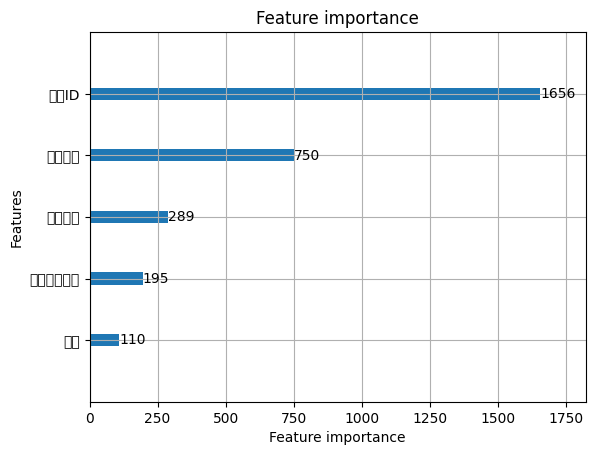

In [25]:
# 12. 피처 중요도 시각화
lgb.plot_importance(model, max_num_features=20)
plt.show()